In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## UNET

In [1]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

if __name__ == "__main__":
    x = torch.randn((2, 3, 512, 512))
    f = build_unet()
    y = f(x)
    print(y.shape)


torch.Size([2, 1, 512, 512])


## LOSS

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

## UTILS

In [3]:

import os
import time
import random
import numpy as np
import cv2
import torch

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


## DATA

In [5]:
# DELETE



# import os
# import numpy as np
# import cv2
# import torch
# from torch.utils.data import Dataset

# class DriveDataset(Dataset):
#     def __init__(self, images_path, masks_path):

#         self.images_path = images_path
#         self.masks_path = masks_path
#         self.n_samples = len(images_path)

#     def __getitem__(self, index):
#         """ Reading image """
#         image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
#         image = image/255.0 ## (512, 512, 3)
#         image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
#         image = image.astype(np.float32)
#         image = torch.from_numpy(image)

#         """ Reading mask """
#         mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
#         mask = mask/255.0   ## (512, 512)
#         mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
#         mask = mask.astype(np.float32)
#         mask = torch.from_numpy(mask)

#         return image, mask

#     def __len__(self):
#         return self.n_samples


In [4]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image_path = self.images_path[index]
        mask_path = self.masks_path[index]

        # Load image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            # Handle missing image gracefully
            print(f"Warning: Could not read image at {image_path}. Using placeholder.")
            image = np.zeros((512, 512, 3), dtype=np.float32)  # Placeholder

        image = image / 255.0  # Normalize to [0, 1]
        image = np.transpose(image, (2, 0, 1))  # (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            # Handle missing mask gracefully
            print(f"Warning: Could not read mask at {mask_path}. Using placeholder.")
            mask = np.zeros((512, 512), dtype=np.float32)  # Placeholder

        mask = mask / 255.0  # Normalize to [0, 1]
        mask = np.expand_dims(mask, axis=0)  # Add channel dimension (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples


## Training

In [13]:
## DELETE, this one saves at every epoch(i guess) and updates by deleting the previous one and replacing it. Meaning, constant dowmload.


# from glob import glob # Added glob import
# from torch.utils.data import DataLoader # Added DataLoader import

# # Train function
# def train(model, loader, optimizer, loss_fn, device):
#     epoch_loss = 0.0
#     model.train()

#     for x, y in loader:
#         x = x.to(device, dtype=torch.float32)
#         y = y.to(device, dtype=torch.float32)

#         optimizer.zero_grad()
#         y_pred = model(x)

#         loss = loss_fn(y_pred, y)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#     epoch_loss = epoch_loss / len(loader)
#     return epoch_loss


# # Evaluate function
# def evaluate(model, loader, loss_fn, device):
#     epoch_loss = 0.0
#     model.eval()

#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(device, dtype=torch.float32)
#             y = y.to(device, dtype=torch.float32)

#             y_pred = model(x)
#             loss = loss_fn(y_pred, y)
#             epoch_loss += loss.item()

#     epoch_loss = epoch_loss / len(loader)
#     return epoch_loss


# # Main script
# if __name__ == "__main__":
#     """ Seeding """
#     torch.manual_seed(42)

#     """ Directories """
#     os.makedirs("files", exist_ok=True)

#     """ Load dataset """
#     train_x = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/train/images/*"))
#     train_y = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/train/masks/*"))
#     valid_x = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/images/*"))
#     valid_y = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/masks/*"))

#     assert len(train_x) == len(train_y), "Mismatch between training images and masks count!"
#     assert len(valid_x) == len(valid_y), "Mismatch between validation images and masks count!"

#     print(f"Dataset Size: Train: {len(train_x)}, Valid: {len(valid_x)}")

#     """ Hyperparameters """
#     H, W = 512, 512
#     batch_size = 2
#     num_epochs = 50
#     lr = 1e-4
#     checkpoint_path = "files/checkpoint.pth"

#     """ Dataset and loader """
#     train_dataset = DriveDataset(train_x, train_y)
#     valid_dataset = DriveDataset(valid_x, valid_y)

#     train_loader = DataLoader(
#         dataset=train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=2
#     )

#     valid_loader = DataLoader(
#         dataset=valid_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=2
#     )

#     """ Device and model """
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = build_unet()  # Replace with your U-Net model
#     model = model.to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
#     loss_fn = DiceBCELoss()  # Replace with your custom loss function

#     """ Training loop """
#     best_valid_loss = float("inf")

#     for epoch in range(num_epochs):
#         start_time = time.time()

#         train_loss = train(model, train_loader, optimizer, loss_fn, device)
#         valid_loss = evaluate(model, valid_loader, loss_fn, device)

#         """ Save the best model """
#         if valid_loss < best_valid_loss:
#             print(f"Validation loss improved from {best_valid_loss:.4f} to {valid_loss:.4f}. Saving model...")
#             best_valid_loss = valid_loss
#             torch.save(model.state_dict(), checkpoint_path)

#         scheduler.step(valid_loss)
#         end_time = time.time()

#         epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)
#         print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_mins}m {epoch_secs}s")
#         print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")


In [1]:
# The main training

from glob import glob  # Added glob import
from torch.utils.data import DataLoader  # Added DataLoader import

# Train function
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0
    model.train()

    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(loader)
    return epoch_loss


# Evaluate function
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(loader)
    return epoch_loss


# Main script
if __name__ == "__main__":
    """ Seeding """
    torch.manual_seed(42)

    """ Directories """
    os.makedirs("files", exist_ok=True)

    # """ Load dataset (drive)"""
    # train_x = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/train/images/*"))
    # train_y = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/train/masks/*"))
    # valid_x = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/images/*"))
    # valid_y = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/masks/*"))

        """ Load dataset (local run)"""
    # train_x = sorted(glob("split_data/train/images/*"))
    # train_y = sorted(glob("split_data/train/masks/*"))
    # valid_x = sorted(glob("split_data/test/images/*"))
    # valid_y = sorted(glob("split_data/test/masks/*"))

    assert len(train_x) == len(train_y), "Mismatch between training images and masks count!"
    assert len(valid_x) == len(valid_y), "Mismatch between validation images and masks count!"

    print(f"Dataset Size: Train: {len(train_x)}, Valid: {len(valid_x)}")

    """ Hyperparameters """
    H, W = 512, 512
    batch_size = 8
    num_epochs = 250
    lr = 1e-4
    # checkpoint_path = "files/final_model.pth"  # Set path for manual saving
    checkpoint_path = '/content/drive/MyDrive/boundary_drive_file/final_model.pth'

    """ Dataset and loader """
    train_dataset = DriveDataset(train_x, train_y)
    valid_dataset = DriveDataset(valid_x, valid_y)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    """ Device and model """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = build_unet()  # Replace with your U-Net model
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()  # Replace with your custom loss function

    """ Training loop """
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        scheduler.step(valid_loss)
        end_time = time.time()

        epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)
        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

    """ Save the model after training """
    # print("Training complete. Saving the final model...")
    # torch.save(model.state_dict(), checkpoint_path)
    # print(f"Model saved to {checkpoint_path}")


## Save model

In [19]:
print("Training complete. Saving the final model...")
torch.save(model.state_dict(), checkpoint_path)
print(f"Model saved to {checkpoint_path}")

Training complete. Saving the final model...
Model saved to /content/files/final_model.pth


## Testing. checks F1 and recall score and accuracy

In [9]:

import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

# from model import build_unet
# from utils import create_dir, seeding

def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/images/*"))
    test_y = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/masks/*"))

    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "/content/drive/MyDrive/boundary_drive_file/final_model.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)


<ipython-input-9-15b106d9dc10>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))
100%|██████████| 17/

Jaccard: 0.6873 - F1: 0.7937 - Recall: 0.8137 - Precision: 0.8121 - Acc: 0.9874
FPS:  0.1054331812884362


## prediction. shows image, truth and mask

<ipython-input-22-6397cc4d79d8>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
  0%|          | 0/17 [0

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/lek_shore1_aug_0.png


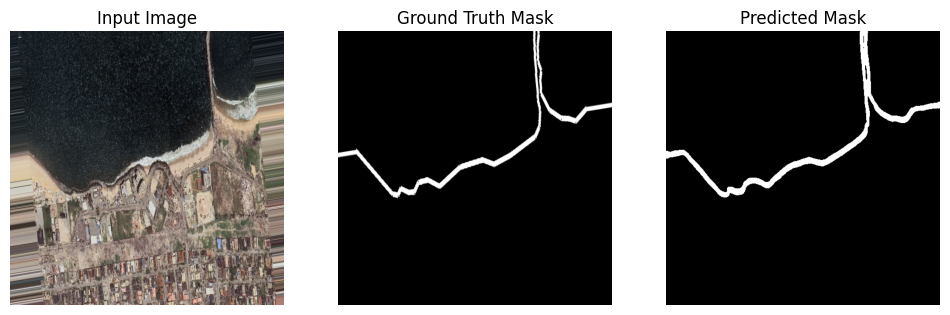

  6%|▌         | 1/17 [00:09<02:39,  9.94s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/lek_shore1_aug_4.png


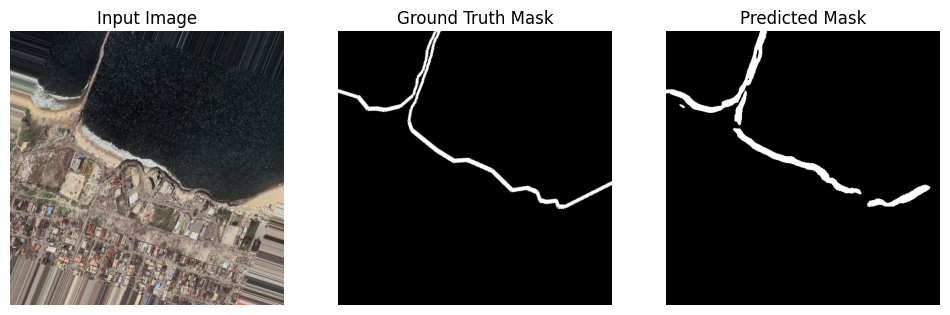

 12%|█▏        | 2/17 [00:21<02:40, 10.67s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/lek_shore3__2018_aug_10.png


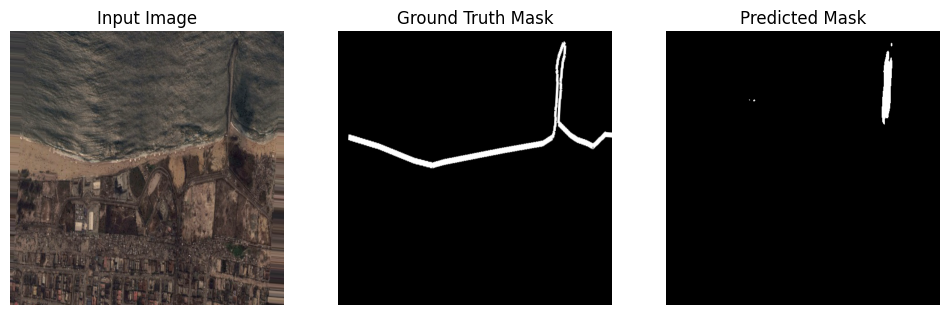

 18%|█▊        | 3/17 [00:31<02:28, 10.59s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/lek_shore3__2018_aug_12.png


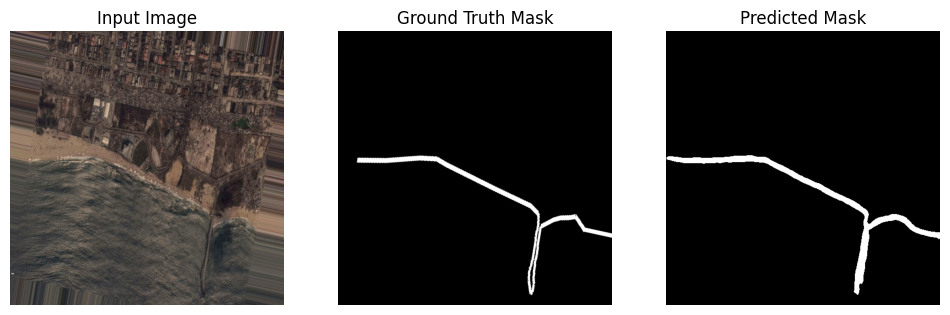

 24%|██▎       | 4/17 [00:41<02:11, 10.14s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/lek_shore4__2016_aug_18.png


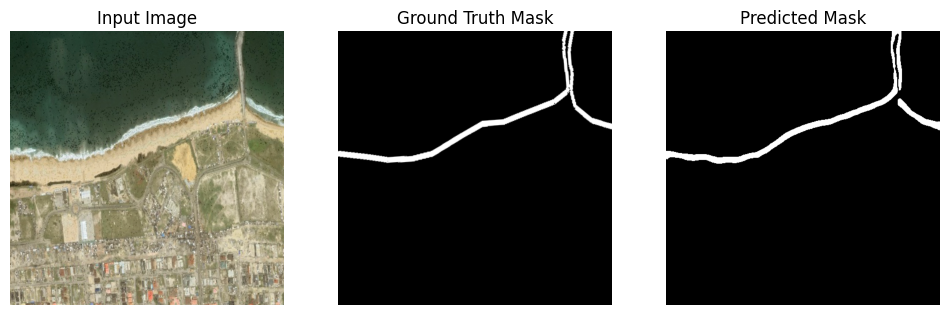

 29%|██▉       | 5/17 [00:52<02:06, 10.52s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p10_aug_22.png


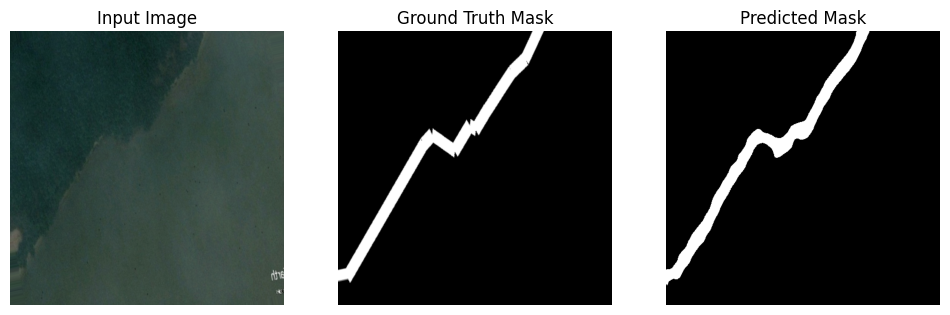

 35%|███▌      | 6/17 [01:03<01:57, 10.67s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p13_aug_33.png


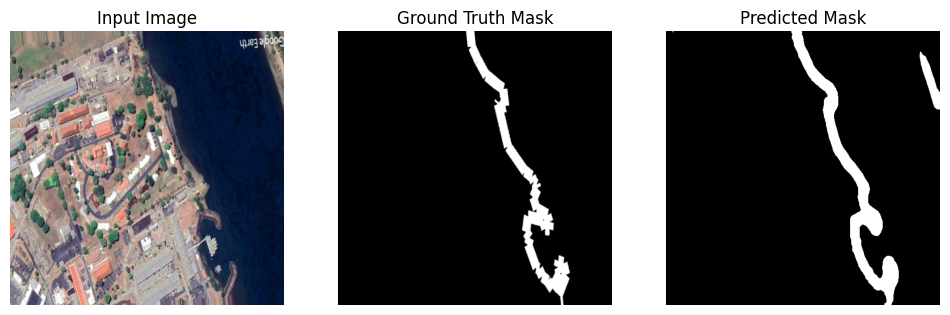

 41%|████      | 7/17 [01:12<01:41, 10.16s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p14_aug_35.png


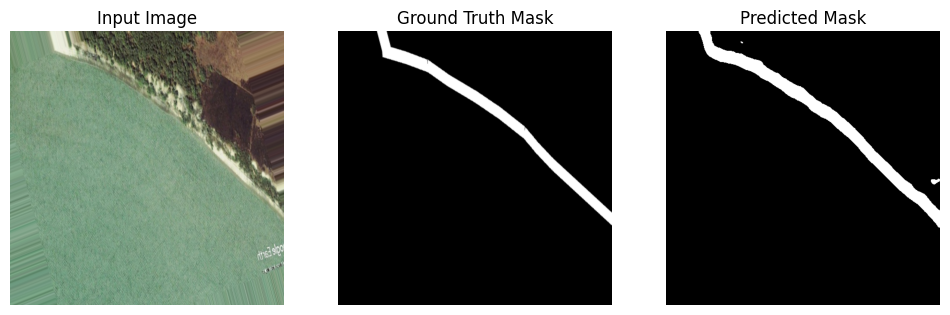

 47%|████▋     | 8/17 [01:25<01:40, 11.15s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p15_aug_40.png


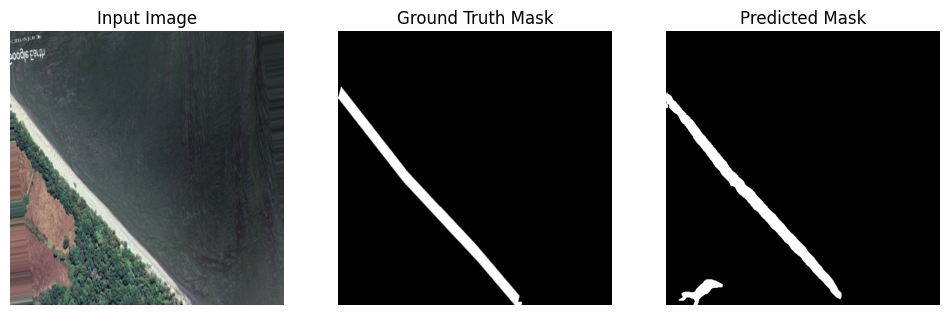

 53%|█████▎    | 9/17 [01:36<01:29, 11.21s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p16_aug_47.png


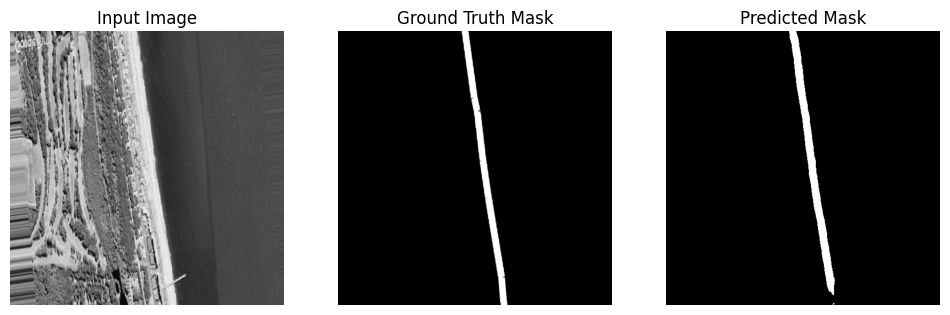

 59%|█████▉    | 10/17 [01:46<01:15, 10.74s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p17_aug_54.png


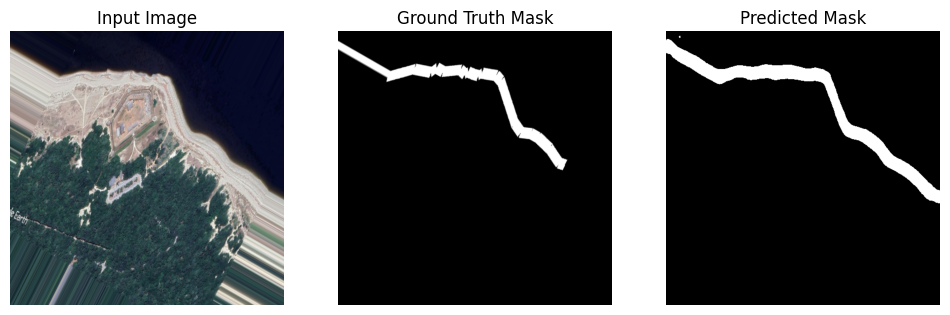

 65%|██████▍   | 11/17 [01:56<01:03, 10.60s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p18_aug_55.png


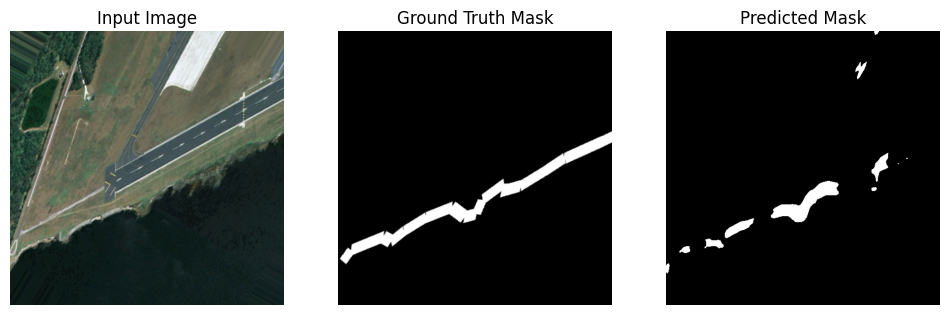

 71%|███████   | 12/17 [02:08<00:53, 10.78s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p5_aug_66.png


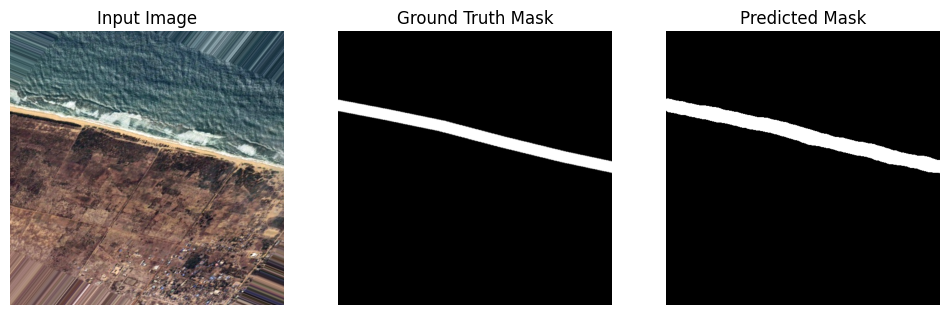

 76%|███████▋  | 13/17 [02:18<00:42, 10.54s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p5_aug_68.png


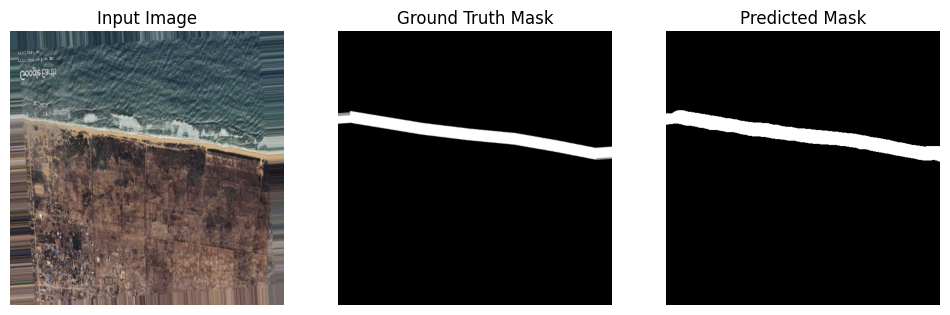

 82%|████████▏ | 14/17 [02:28<00:31, 10.35s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p7_aug_72.png


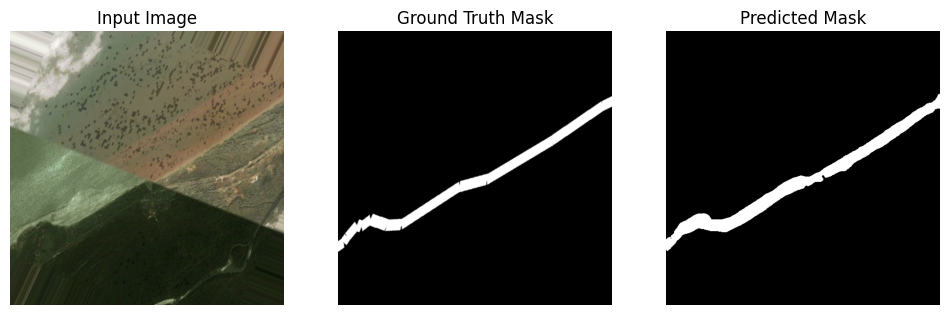

 88%|████████▊ | 15/17 [02:39<00:21, 10.55s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p8_aug_78.png


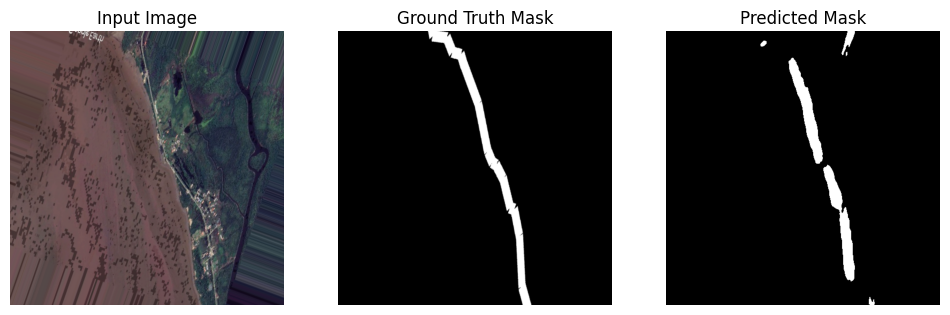

 94%|█████████▍| 16/17 [02:49<00:10, 10.46s/it]

Saved: /content/drive/MyDrive/boundary_drive_file/results_0p1/p9_aug_82.png


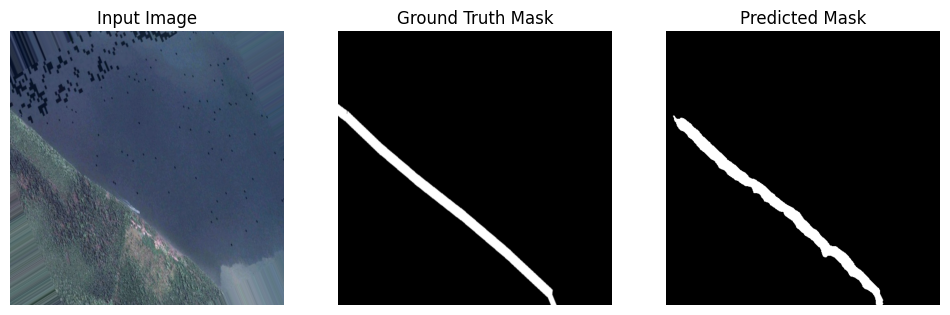

100%|██████████| 17/17 [02:59<00:00, 10.53s/it]

Jaccard: 0.6038 | F1: 0.7367 | Recall: 0.8614 | Precision: 0.6681 | Accuracy: 0.9837
FPS: 0.10


In [22]:
# prediction. shows image, truth and mask


import os
import time
import numpy as np
from glob import glob
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score, recall_score, precision_score, accuracy_score


def mask_parse(mask):
    """Prepare mask for visualization."""
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = np.concatenate([mask, mask, mask], axis=-1)  # Convert to 3 channels
    return mask


def calculate_metrics(y_true, y_pred):
    """Calculate metrics between ground truth and predictions."""
    y_true = y_true.cpu().numpy().reshape(-1).astype(np.uint8)
    y_pred = y_pred.cpu().numpy().reshape(-1).astype(np.uint8)

    return {
        "jaccard": jaccard_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "accuracy": accuracy_score(y_true, y_pred),
    }


if __name__ == "__main__":
    """Test setup."""
    test_images = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/images/*"))
    test_masks = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/masks/*"))

    model_path = "/content/drive/MyDrive/boundary_drive_file/final_model.pth"  # Trained model path
    results_dir = "/content/drive/MyDrive/boundary_drive_file/results_0p1"  # Directory to save visualizations
    os.makedirs(results_dir, exist_ok=True)

    H, W = 512, 512  # Image dimensions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    """Load trained model."""
    model = build_unet()  # Replace with your model definition
    model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    metrics_sum = {"jaccard": 0, "f1": 0, "recall": 0, "precision": 0, "accuracy": 0}
    total_time = []

    """Process each test sample."""
    for image_path, mask_path in tqdm(zip(test_images, test_masks), total=len(test_images)):
        name = os.path.basename(image_path).split(".")[0]

        # Read and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (W, H))
        x = np.transpose(image, (2, 0, 1)) / 255.0  # Normalize and rearrange to (C, H, W)
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        # Read and preprocess the mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (W, H))
        y_true = torch.tensor(mask / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Predict mask
        start_time = time.time()
        with torch.no_grad():
            pred_mask = model(x)
            pred_mask = torch.sigmoid(pred_mask) > 0.1
        total_time.append(time.time() - start_time)

        # Calculate metrics
        metrics = calculate_metrics(y_true, pred_mask)
        for key in metrics_sum:
            metrics_sum[key] += metrics[key]

        # Visualize results
        pred_mask_np = (pred_mask[0, 0].cpu().numpy() * 255).astype(np.uint8)
        y_true_np = (y_true[0, 0].cpu().numpy() * 255).astype(np.uint8)

        ori_mask = mask_parse(y_true_np)
        pred_mask_viz = mask_parse(pred_mask_np)

        # Display using Matplotlib
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(ori_mask)
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_viz)
        plt.title("Predicted Mask")
        plt.axis("off")

        # Save the visualization as a single image
        combined_path = os.path.join(results_dir, f"{name}.png")
        plt.savefig(combined_path)
        print(f"Saved: {combined_path}")
        plt.show()

    # Print overall metrics
    num_samples = len(test_images)
    for key in metrics_sum:
        metrics_sum[key] /= num_samples

    print(
        f"Jaccard: {metrics_sum['jaccard']:.4f} | F1: {metrics_sum['f1']:.4f} | "
        f"Recall: {metrics_sum['recall']:.4f} | Precision: {metrics_sum['precision']:.4f} | "
        f"Accuracy: {metrics_sum['accuracy']:.4f}"
    )

    print(f"FPS: {1 / np.mean(total_time):.2f}")


## Exporting predicted masks

In [ ]:
import os
import time
import numpy as np
from glob import glob
import cv2
import torch
from tqdm import tqdm


def calculate_metrics(y_true, y_pred):
    """Calculate metrics between ground truth and predictions."""
    y_true = y_true.cpu().numpy().reshape(-1).astype(np.uint8)
    y_pred = y_pred.cpu().numpy().reshape(-1).astype(np.uint8)

    return {
        "jaccard": jaccard_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "accuracy": accuracy_score(y_true, y_pred),
    }


if __name__ == "__main__":
    """Test setup."""
    test_images = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/images/*"))
    test_masks = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/masks/*"))

    model_path = "/content/drive/MyDrive/boundary_drive_file/final_model.pth"  # Trained model path
    results_dir = "/content/drive/MyDrive/boundary_drive_file/predicted_masks"  # Directory to save predicted masks
    os.makedirs(results_dir, exist_ok=True)

    H, W = 512, 512  # Image dimensions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    """Load trained model."""
    model = build_unet()  # Replace with your model definition
    model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    total_time = []

    """Process each test sample."""
    for image_path, mask_path in tqdm(zip(test_images, test_masks), total=len(test_images)):
        name = os.path.basename(image_path).split(".")[0]

        # Read and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (W, H))
        x = np.transpose(image, (2, 0, 1)) / 255.0  # Normalize and rearrange to (C, H, W)
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        # Predict mask
        start_time = time.time()
        with torch.no_grad():
            pred_mask = model(x)
            pred_mask = (torch.sigmoid(pred_mask) > 0.1).float()
        total_time.append(time.time() - start_time)

        # Save predicted mask
        pred_mask_np = (pred_mask[0, 0].cpu().numpy() * 255).astype(np.uint8)
        save_path = os.path.join(results_dir, f"{name}_predicted.png")
        cv2.imwrite(save_path, pred_mask_np)
        print(f"Saved predicted mask: {save_path}")

    print(f"FPS: {1 / np.mean(total_time):.2f}")


## Testing on images

In [23]:
import os
import time
import numpy as np
from glob import glob
import cv2
import torch
from tqdm import tqdm


def calculate_metrics(y_true, y_pred):
    """Calculate metrics between ground truth and predictions."""
    y_true = y_true.cpu().numpy().reshape(-1).astype(np.uint8)
    y_pred = y_pred.cpu().numpy().reshape(-1).astype(np.uint8)

    return {
        "jaccard": jaccard_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "accuracy": accuracy_score(y_true, y_pred),
    }


if __name__ == "__main__":
    """Test setup."""
    test_images = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/images/*"))
    test_masks = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/masks/*"))

    model_path = "/content/drive/MyDrive/boundary_drive_file/final_model.pth"  # Trained model path
    results_dir = "/content/drive/MyDrive/boundary_drive_file/predicted_masks"  # Directory to save predicted masks
    os.makedirs(results_dir, exist_ok=True)

    H, W = 512, 512  # Image dimensions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    """Load trained model."""
    model = build_unet()  # Replace with your model definition
    model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    total_time = []

    """Process each test sample."""
    for image_path, mask_path in tqdm(zip(test_images, test_masks), total=len(test_images)):
        name = os.path.basename(image_path).split(".")[0]

        # Read and preprocess the image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (W, H))
        x = np.transpose(image, (2, 0, 1)) / 255.0  # Normalize and rearrange to (C, H, W)
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        # Predict mask
        start_time = time.time()
        with torch.no_grad():
            pred_mask = model(x)
            pred_mask = (torch.sigmoid(pred_mask) > 0.1).float()
        total_time.append(time.time() - start_time)

        # Save predicted mask
        pred_mask_np = (pred_mask[0, 0].cpu().numpy() * 255).astype(np.uint8)
        save_path = os.path.join(results_dir, f"{name}_predicted.png")
        cv2.imwrite(save_path, pred_mask_np)
        print(f"Saved predicted mask: {save_path}")

    print(f"FPS: {1 / np.mean(total_time):.2f}")


<ipython-input-23-11bfc36a2f56>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
  6%|▌         | 1/17 [0

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/lek_shore1_aug_0_predicted.png


 12%|█▏        | 2/17 [00:18<02:19,  9.31s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/lek_shore1_aug_4_predicted.png


 18%|█▊        | 3/17 [00:28<02:16,  9.73s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/lek_shore3__2018_aug_10_predicted.png


 24%|██▎       | 4/17 [00:37<01:59,  9.20s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/lek_shore3__2018_aug_12_predicted.png


 29%|██▉       | 5/17 [00:47<01:55,  9.60s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/lek_shore4__2016_aug_18_predicted.png


 35%|███▌      | 6/17 [00:57<01:47,  9.76s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p10_aug_22_predicted.png


 41%|████      | 7/17 [01:05<01:33,  9.32s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p13_aug_33_predicted.png


 47%|████▋     | 8/17 [01:16<01:27,  9.69s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p14_aug_35_predicted.png


 53%|█████▎    | 9/17 [01:25<01:16,  9.59s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p15_aug_40_predicted.png


 59%|█████▉    | 10/17 [01:34<01:05,  9.41s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p16_aug_47_predicted.png


 65%|██████▍   | 11/17 [01:45<00:58,  9.70s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p17_aug_54_predicted.png


 71%|███████   | 12/17 [01:53<00:47,  9.41s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p18_aug_55_predicted.png


 76%|███████▋  | 13/17 [02:03<00:38,  9.51s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p5_aug_66_predicted.png


 82%|████████▏ | 14/17 [02:13<00:29,  9.73s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p5_aug_68_predicted.png


 88%|████████▊ | 15/17 [02:25<00:20, 10.19s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p7_aug_72_predicted.png


 94%|█████████▍| 16/17 [02:34<00:09,  9.95s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p8_aug_78_predicted.png


100%|██████████| 17/17 [02:44<00:00,  9.70s/it]

Saved predicted mask: /content/drive/MyDrive/boundary_drive_file/predicted_masks/p9_aug_82_predicted.png
FPS: 0.10


## training with accuracy score

In [ ]:
# from glob import glob  # Added glob import
# from torch.utils.data import DataLoader  # Added DataLoader import

# # Accuracy function
# def calculate_accuracy(y_pred, y_true, threshold=0.5):
#     """Calculate the accuracy of predictions based on a threshold."""
#     y_pred = (y_pred > threshold).float()
#     correct = (y_pred == y_true).float().sum()
#     total = y_true.numel()
#     return correct / total


# # Train function
# def train(model, loader, optimizer, loss_fn, device):
#     epoch_loss = 0.0
#     epoch_accuracy = 0.0
#     model.train()

#     for x, y in loader:
#         x = x.to(device, dtype=torch.float32)
#         y = y.to(device, dtype=torch.float32)

#         optimizer.zero_grad()
#         y_pred = model(x)

#         loss = loss_fn(y_pred, y)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         epoch_accuracy += calculate_accuracy(y_pred, y).item()

#     epoch_loss = epoch_loss / len(loader)
#     epoch_accuracy = epoch_accuracy / len(loader)
#     return epoch_loss, epoch_accuracy


# # Evaluate function
# def evaluate(model, loader, loss_fn, device):
#     epoch_loss = 0.0
#     epoch_accuracy = 0.0
#     model.eval()

#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(device, dtype=torch.float32)
#             y = y.to(device, dtype=torch.float32)

#             y_pred = model(x)
#             loss = loss_fn(y_pred, y)

#             epoch_loss += loss.item()
#             epoch_accuracy += calculate_accuracy(y_pred, y).item()

#     epoch_loss = epoch_loss / len(loader)
#     epoch_accuracy = epoch_accuracy / len(loader)
#     return epoch_loss, epoch_accuracy


# # Main script
# if __name__ == "__main__":
#     """ Seeding """
#     torch.manual_seed(42)

#     """ Directories """
#     os.makedirs("files", exist_ok=True)

#     """ Load dataset """
#     train_x = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/train/images/*"))
#     train_y = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/train/masks/*"))
#     valid_x = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/images/*"))
#     valid_y = sorted(glob("/content/drive/MyDrive/boundary_drive_file/split_data/test/masks/*"))

#     assert len(train_x) == len(train_y), "Mismatch between training images and masks count!"
#     assert len(valid_x) == len(valid_y), "Mismatch between validation images and masks count!"

#     print(f"Dataset Size: Train: {len(train_x)}, Valid: {len(valid_x)}")

#     """ Hyperparameters """
#     H, W = 512, 512
#     batch_size = 2
#     num_epochs = 50
#     lr = 1e-4
#     checkpoint_path = "files/final_model.pth"  # Set path for manual saving

#     """ Dataset and loader """
#     train_dataset = DriveDataset(train_x, train_y)
#     valid_dataset = DriveDataset(valid_x, valid_y)

#     train_loader = DataLoader(
#         dataset=train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=2
#     )

#     valid_loader = DataLoader(
#         dataset=valid_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=2
#     )

#     """ Device and model """
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = build_unet()  # Replace with your U-Net model
#     model = model.to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
#     loss_fn = DiceBCELoss()  # Replace with your custom loss function

#     """ Training loop """
#     for epoch in range(num_epochs):
#         start_time = time.time()

#         train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
#         valid_loss, valid_acc = evaluate(model, valid_loader, loss_fn, device)

#         scheduler.step(valid_loss)
#         end_time = time.time()

#         epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)
#         print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_mins}m {epoch_secs}s")
#         print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
#         print(f"Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_acc:.4f}")

#     """ Save the model after training """
#     print("Training complete. Saving the final model...")
#     torch.save(model.state_dict(), checkpoint_path)
#     print(f"Model saved to {checkpoint_path}")
